In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [ ]:
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

## Exploratory data analysis

### Load and preprocess the dataset

In [ ]:
df = pd.read_csv("Churn_Modelling.csv")
# set aside 20% rows as hold-out test set, chosen at random from the full dataset
df_raw, df_test = train_test_split(df, test_size = 0.2, random_state = 319)
display(df_raw.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4347,4348,15645271,Radcliffe-Brown,615,Germany,Male,24,8,108528.07,2,0,0,179488.41,1
4024,4025,15758073,Dellucci,655,France,Female,20,7,134397.61,1,0,0,28029.54,0
1630,1631,15634950,Obiajulu,657,Germany,Male,57,8,107174.58,1,1,1,126369.55,1
6012,6013,15654183,Aitken,738,France,Female,26,3,0.00,2,1,0,67484.16,0
9323,9324,15815316,Kennedy,644,France,Male,50,9,76817.00,4,1,0,196371.13,1


In [ ]:
display(df_raw.shape)
display(df_raw.info())

(8000, 14)

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4347 to 3873
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
 13  Exited           8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 937.5+ KB


None

In [ ]:
unique_values = df_raw.nunique()
unique_values = unique_values.reset_index()
unique_values.columns = ['Columns', 'Unique_values_count']
display(unique_values)

,Columns,Unique_values_count
0,RowNumber,8000
1,CustomerId,8000
2,Surname,2591
3,CreditScore,456
4,Geography,3
5,Gender,2
6,Age,68
7,Tenure,11
8,Balance,5105
9,NumOfProducts,4


In [ ]:
df_raw.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace = True)
display(df_raw.shape)

(8000, 11)

In [ ]:
df_raw = df_raw .drop_duplicates()
display(df_raw.shape)

(8000, 11)

### Initial look at the features

In [ ]:
df_raw['CreditScore'].describe()

,CreditScore
count,8000.000000
mean,650.437375
std,96.966797
min,350.000000
25%,583.000000
50%,651.000000
75%,718.000000
max,850.000000


In [ ]:
df_raw['Age'].describe()

,Age
count,8000.000000
mean,38.825625
std,10.463551
min,18.000000
25%,32.000000
50%,37.000000
75%,44.000000
max,92.000000


In [ ]:
df_raw['Balance'].describe()

,Balance
count,8000.000000
mean,76477.277910
std,62428.546768
min,0.000000
25%,0.000000
50%,97113.395000
75%,127710.560000
max,250898.090000


In [ ]:
df_raw['EstimatedSalary'].describe()

,EstimatedSalary
count,8000.000000
mean,100032.487771
std,57634.366650
min,11.580000
25%,50416.850000
50%,100502.325000
75%,149291.972500
max,199992.480000


In [ ]:
df_raw['Tenure'].value_counts(normalize = 1)

,proportion
Tenure,
1,0.10525
8,0.10350
2,0.10300
7,0.10275
6,0.10200
5,0.10100
3,0.10025
9,0.09650
4,0.09650


In [ ]:
df_raw['NumOfProducts'].value_counts(normalize = 1)

,proportion
NumOfProducts,
1,0.508750
2,0.458875
3,0.026125
4,0.006250


In [ ]:
df_raw['HasCrCard'].value_counts(normalize = 1)

,proportion
HasCrCard,
1,0.706625
0,0.293375


In [ ]:
df_raw['IsActiveMember'].value_counts(normalize = 1)

,proportion
IsActiveMember,
1,0.51625
0,0.48375


In [ ]:
df_raw['Geography'].value_counts(normalize = 1)

,proportion
Geography,
France,0.49775
Germany,0.25350
Spain,0.24875


In [ ]:
df_raw['Gender'].value_counts(normalize = 1)

,proportion
Gender,
Male,0.543875
Female,0.456125


In [ ]:
df_raw['Exited'].value_counts(normalize = 1)

,proportion
Exited,
0,0.79475
1,0.20525


### Break out by the characteristics

In [ ]:
# Gender-wise mean and variance of Balance and Age
gender_balance_stats = df_raw.groupby('Gender')['Balance'].agg(['mean', 'var']).rename(columns={'mean': 'Balance_Mean', 'var': 'Balance_Variance'})
gender_age_stats = df_raw.groupby('Gender')['Age'].agg(['mean', 'var']).rename(columns={'mean': 'Age_Mean', 'var': 'Age_Variance'})
gender_cr_stats = df_raw.groupby('Gender')['CreditScore'].agg(['mean', 'var']).rename(columns={'mean': 'CreditScore_Mean', 'var': 'CreditScore_Variance'})
print(gender_balance_stats)
print(gender_age_stats)
print(gender_cr_stats)

# IsActiveMember-wise mean and variance of Balance and Age
active_balance_stats = df_raw.groupby('IsActiveMember')['Balance'].agg(['mean', 'var']).rename(columns={'mean': 'Balance_Mean', 'var': 'Balance_Variance'})
active_age_stats = df_raw.groupby('IsActiveMember')['Age'].agg(['mean', 'var']).rename(columns={'mean': 'Age_Mean', 'var': 'Age_Variance'})
active_cr_stats = df_raw.groupby('IsActiveMember')['CreditScore'].agg(['mean', 'var']).rename(columns={'mean': 'CreditScore_Mean', 'var': 'CreditScore_Variance'})
print(active_balance_stats)
print(active_age_stats)
print(active_cr_stats)

# Geography-wise mean and variance of Balance and Age
geography_balance_stats = df_raw.groupby('Geography')['Balance'].agg(['mean', 'var']).rename(columns={'mean': 'Balance_Mean', 'var': 'Balance_Variance'})
geography_age_stats = df_raw.groupby('Geography')['Age'].agg(['mean', 'var']).rename(columns={'mean': 'Age_Mean', 'var': 'Age_Variance'})
geography_cr_stats = df_raw.groupby('Geography')['CreditScore'].agg(['mean', 'var']).rename(columns={'mean': 'CreditScore_Mean', 'var': 'CreditScore_Variance'})
print(geography_balance_stats)
print(geography_age_stats)
print(geography_cr_stats)


        Balance_Mean  Balance_Variance
Gender                                
Female  75609.410839      3.852210e+09
Male    77205.121381      3.934891e+09
         Age_Mean  Age_Variance
Gender                         
Female  39.069608    110.083421
Male    38.621007    108.918170
        CreditScore_Mean  CreditScore_Variance
Gender                                        
Female        652.257879           9417.715004
Male          648.910595           9386.899821
                Balance_Mean  Balance_Variance
IsActiveMember                                
0               76656.766966      3.932482e+09
1               76309.088407      3.865265e+09
                 Age_Mean  Age_Variance
IsActiveMember                         
0               37.933075     79.960627
1               39.661985    135.732170
                CreditScore_Mean  CreditScore_Variance
IsActiveMember                                        
0                     648.741344            9669.71416
1              

### Feature engineering

In [ ]:
# Map 'Gender' column: Male -> 0, Female -> 1
df_raw['Gender'] = df_raw['Gender'].map({'Male': 0, 'Female': 1})

# Create dummy variables for 'Geography' column
# Setting "drop_first=True" drops the first category in the dummy variable columns. This can help avoid multicollinearity
df_raw = pd.get_dummies(df_raw, columns=['Geography'], drop_first=True)
dummy_columns = [col for col in df_raw.columns if 'Geography_' in col]
df_raw[dummy_columns] = df_raw[dummy_columns].astype(int)
display(df_raw.head())

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
4347,615,0,24,8,108528.07,2,0,0,179488.41,1,1,0
4024,655,1,20,7,134397.61,1,0,0,28029.54,0,0,0
1630,657,0,57,8,107174.58,1,1,1,126369.55,1,1,0
6012,738,1,26,3,0.00,2,1,0,67484.16,0,0,0
9323,644,0,50,9,76817.00,4,1,0,196371.13,1,0,0


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4347 to 3873
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   int64  
 1   Gender             8000 non-null   int64  
 2   Age                8000 non-null   int64  
 3   Tenure             8000 non-null   int64  
 4   Balance            8000 non-null   float64
 5   NumOfProducts      8000 non-null   int64  
 6   HasCrCard          8000 non-null   int64  
 7   IsActiveMember     8000 non-null   int64  
 8   EstimatedSalary    8000 non-null   float64
 9   Exited             8000 non-null   int64  
 10  Geography_Germany  8000 non-null   int64  
 11  Geography_Spain    8000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 812.5 KB


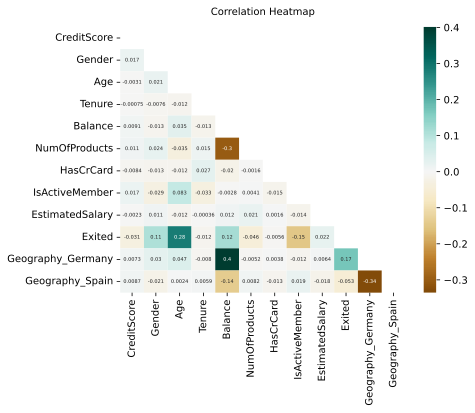

In [ ]:
# Correlation matrix shows the bivariate relationship between variables
mask = np.triu(np.ones_like(df_raw.corr(), dtype = bool))
heatmap = sns.heatmap(df_raw.corr(),
annot = True, mask = mask, cmap = 'BrBG', center = 0, annot_kws = {"size": 5})
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize': 10}, pad = 12);

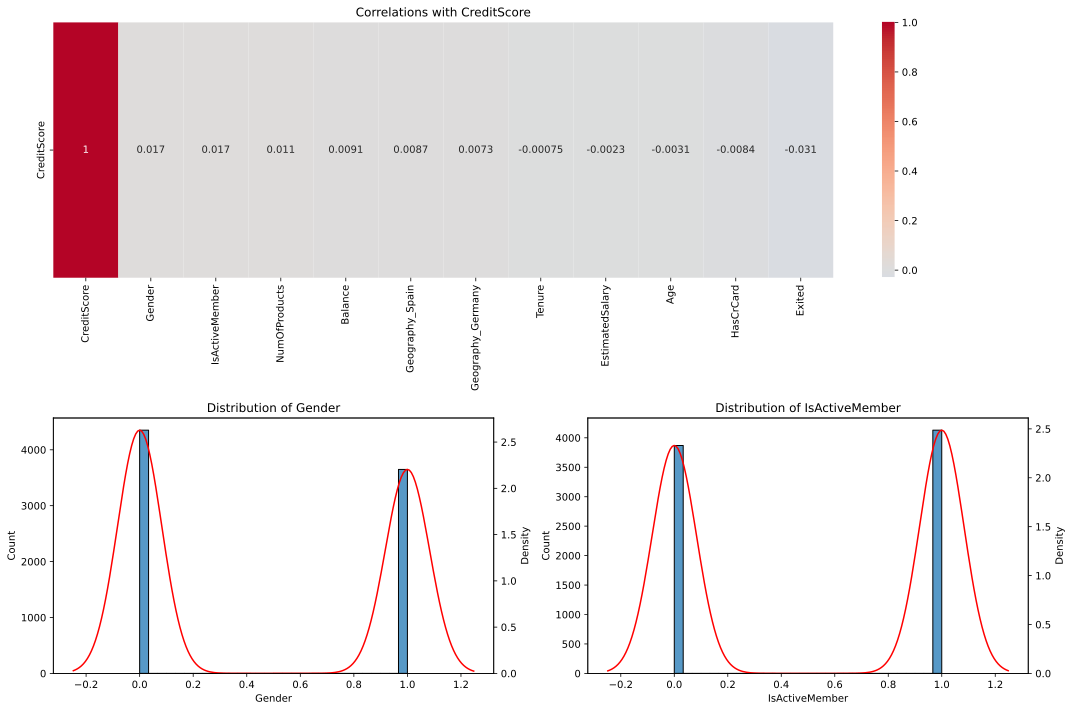


Correlations with CreditScore:

Strongest correlations:
Gender             0.017194
IsActiveMember     0.016932
NumOfProducts      0.011177
Balance            0.009114
Geography_Spain    0.008674
Name: CreditScore, dtype: float64

Weakest correlations:
Tenure            -0.000751
EstimatedSalary   -0.002273
Age               -0.003141
HasCrCard         -0.008365
Exited            -0.030803
Name: CreditScore, dtype: float64


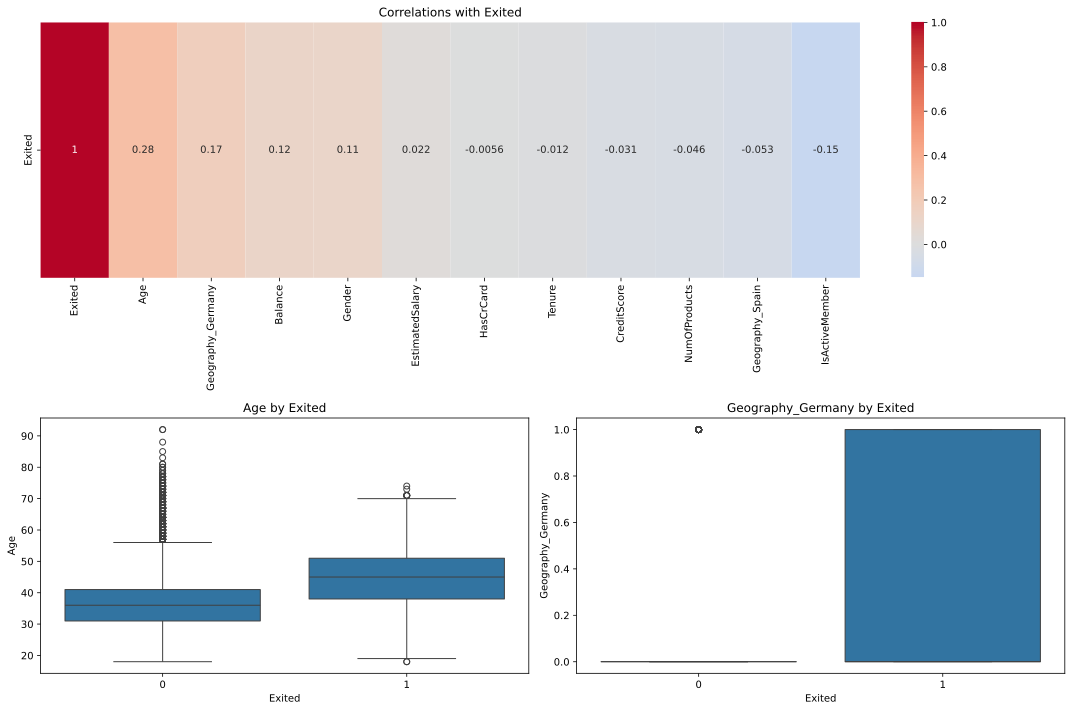


Correlations with Exited:

Strongest correlations:
Age                  0.283003
Geography_Germany    0.168440
Balance              0.118343
Gender               0.105662
EstimatedSalary      0.022093
Name: Exited, dtype: float64

Weakest correlations:
Tenure            -0.011889
CreditScore       -0.030803
NumOfProducts     -0.046285
Geography_Spain   -0.053300
IsActiveMember    -0.150297
Name: Exited, dtype: float64


In [ ]:
# Function to create correlation plots for each target
def plot_target_correlations(df, target, n_top=5):
    # Calculate correlations with target
    correlations = df.corr()[target].sort_values(ascending=False)

    # Create subplots for correlation heatmap and plots
    fig = plt.figure(figsize=(15, 10))

    # Correlation heatmap
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    corr_data = pd.DataFrame(correlations).T
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0)
    ax1.set_title(f'Correlations with {target}')

    # Plots for top correlations
    top_features = correlations[1:n_top+1].index
    for idx, feature in enumerate(top_features[:2]):
        ax = plt.subplot2grid((2, 2), (1, idx))
        if df[target].nunique() <= 2:  # For binary target (Exited)
            # Use boxplot for binary target
            sns.boxplot(x=target, y=feature, data=df, ax=ax)
            ax.set_title(f'{feature} by {target}')
        else:  # For continuous target (CreditScore)
            # Use histogram for continuous target
            sns.histplot(data=df, x=feature, bins=30, ax=ax)
            ax2 = ax.twinx()  # Create twin axis for density plot
            sns.kdeplot(data=df, x=feature, ax=ax2, color='red')
            ax2.set_ylabel('Density')
            ax.set_title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()

    # Print correlation values
    print(f"\nCorrelations with {target}:")
    print("\nStrongest correlations:")
    print(correlations[1:6])  # Top 5 excluding self-correlation
    print("\nWeakest correlations:")
    print(correlations[-5:])  # Bottom 5

# Analyze correlations for both target variables
plot_target_correlations(df_raw, 'CreditScore')
plot_target_correlations(df_raw, 'Exited')

# Additional analysis for unexpected correlations
unexpected_pairs = [
    ('EstimatedSalary', 'CreditScore'),
    ('Tenure', 'Exited'),
    ('Balance', 'EstimatedSalary')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (var1, var2) in enumerate(unexpected_pairs):
    sns.scatterplot(data=df_raw, x=var1, y=var2, ax=axes[idx])
    axes[idx].set_title(f'{var1} vs {var2}')
    correlation = df_raw[var1].corr(df_raw[var2])
    axes[idx].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                  transform=axes[idx].transAxes)
plt.tight_layout()
plt.show()

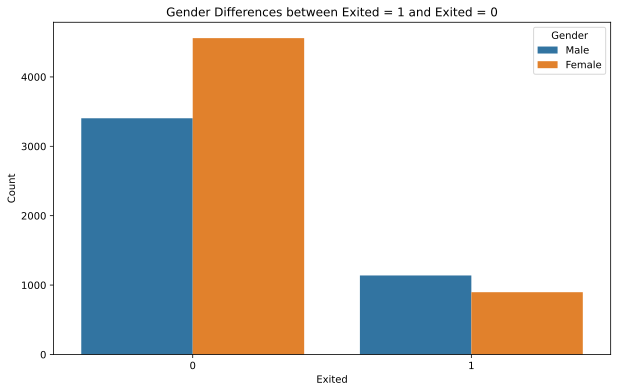

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Exited', hue='Gender', data=df)
plt.title('Gender Differences between Exited = 1 and Exited = 0')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.legend(title='Gender', labels=['Male', 'Female'])
plt.show()


In [ ]:
# Detect data point whose z-score is outside the specified range (3 std)
def outliers_count(df):
  z_scores = df.apply(zscore)
  threshold = 3
  condition = np.abs(z_scores) > threshold
  outliers_count = condition.apply(lambda col: col.sum())
  outliers_count = outliers_count.reset_index()
  outliers_count.columns = ['Columns', '#_of_outliers']
  return outliers_count

In [ ]:
outliers_count(df_raw)

,Columns,#_of_outliers
0,CreditScore,8
1,Gender,0
2,Age,103
3,Tenure,0
4,Balance,0
5,NumOfProducts,50
6,HasCrCard,0
7,IsActiveMember,0
8,EstimatedSalary,0
9,Exited,0


In [ ]:
# Applying Winsorization with a cap at the 5th and 95th percentiles.
# This will limit extreme values, capping values below the 5th percentile and above the 95th percentile.
df_raw['Age'] = winsorize(df_raw['Age'], limits=[0.05, 0.05])
df_raw['NumOfProducts'] = winsorize(df_raw['NumOfProducts'], limits=[0.05, 0.05])
df_raw['CreditScore'] = winsorize(df_raw['CreditScore'], limits=[0.05, 0.05])
outliers_count(df_raw)

,Columns,#_of_outliers
0,CreditScore,0
1,Gender,0
2,Age,0
3,Tenure,0
4,Balance,0
5,NumOfProducts,0
6,HasCrCard,0
7,IsActiveMember,0
8,EstimatedSalary,0
9,Exited,0


In [ ]:
# set aside another 20% rows used for unbiased estimate of the test error, chosen at random from the remaining 80% dataset
# the remaining 60% rows are used for model training, hyperparameter tuning, and model selection with CV
df_cv, df_est = train_test_split(df_raw, test_size = 0.25, random_state = 319)

In [ ]:
display(df_cv.shape)

(6000, 12)

## Regression task on predicting the continuous outcome variable 'CreditScore'

In [ ]:
X_reg = df_cv.drop(columns = ['CreditScore', 'Exited'])
y_reg = df_cv['CreditScore']

In [ ]:
# VIF score of an independent variable represents how well the variable is explained by other independent variables
def calculate_vif(df):
  vif_data = pd.DataFrame()
  vif_data['feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  return vif_data

calculate_vif(X_reg)

,feature,VIF
0,Gender,1.814692
1,Age,11.003539
2,Tenure,3.804612
3,Balance,2.986947
4,NumOfProducts,7.729078
5,HasCrCard,3.276207
6,IsActiveMember,2.054258
7,EstimatedSalary,3.796509
8,Geography_Germany,1.785472
9,Geography_Spain,1.481402


We can see here that 'Age' has a high VIF value exceeding 10, indicating it can be predicted by other independent variables in the dataset (multicollinearity).

In [ ]:
# Standardize the predictors
scaler_X_reg = StandardScaler()
scaler_y_reg = StandardScaler()

X_reg_scaled = scaler_X_reg.fit_transform(X_reg)
y_reg_scaled = scaler_y_reg.fit_transform(y_reg.values.reshape(-1, 1)).flatten()

### OLS baseline

In [ ]:
ols = LinearRegression(n_jobs=-1)
ols.fit(X_reg_scaled, y_reg_scaled)  # Fit the model
rmse_baseline = -np.mean(cross_val_score(ols, X_reg_scaled, y_reg_scaled, scoring='neg_root_mean_squared_error', cv=5))
print(f"RMSE of the baseline OLS model: {rmse_baseline}")
print("Coefficients:", ols.coef_)
print("Intercept:", ols.intercept_)

RMSE of the baseline OLS model: 1.0023423993194827
Coefficients: [ 0.02348579  0.00071525  0.00938025  0.0262293   0.01898142 -0.00413392
  0.013733    0.00330675 -0.00438946  0.00566022]
Intercept: 5.092203883352138e-16


### OLS Without 'Age'


In [ ]:
# Define predictors and target variable for regression without 'Age'
X_reg_no_age = df_cv.drop(columns=['CreditScore', 'Exited', 'Age'])
X_reg_no_age_scaler = StandardScaler()
X_reg_no_age_scaled= X_reg_no_age_scaler.fit_transform(X_reg_no_age)

# Fit the OLS model without 'Age'
ols_no_age = LinearRegression(n_jobs=-1)
ols_no_age.fit(X_reg_no_age_scaled, y_reg_scaled)

# Calculate RMSE using cross-validation
rmse_baseline_no_age = -np.mean(cross_val_score(ols_no_age, X_reg_no_age_scaled, y_reg_scaled, scoring='neg_root_mean_squared_error', cv=5))

# Print results
print(f"RMSE of the OLS model without 'Age': {rmse_baseline_no_age}")
print("Coefficients:", ols_no_age.coef_)
print("Intercept:", ols_no_age.intercept_)

RMSE of the OLS model without 'Age': 1.0018294943456643
Coefficients: [ 0.02350212  0.00936936  0.02621517  0.01892752 -0.00412995  0.01379044
  0.00331248 -0.00434422  0.00567927]
Intercept: 5.089937320894534e-16


### Principal Component Regression

In [ ]:
# Iterate over different numbers of principal components
components_range = range(1, X_reg.shape[1] + 1)  # 1 to number of features 11
rmse_scores_pca = []

for n_components in components_range:
    pca = PCA(n_components = n_components)
    X_reg_pca = pca.fit_transform(X_reg_scaled)

    pcr = LinearRegression(n_jobs=-1)
    rmse_pca = -np.mean(cross_val_score(pcr, X_reg_pca, y_reg_scaled, scoring='neg_root_mean_squared_error', cv=5))
    rmse_scores_pca.append(rmse_pca)
    print(f"Number of components: {n_components}, RMSE: {rmse_pca}")

Number of components: 1, RMSE: 1.000275093354425
Number of components: 2, RMSE: 1.0005946018915588
Number of components: 3, RMSE: 1.0007204886005092
Number of components: 4, RMSE: 1.0012787342040181
Number of components: 5, RMSE: 1.0013376597862165
Number of components: 6, RMSE: 1.0014556603752478
Number of components: 7, RMSE: 1.0017466968938524
Number of components: 8, RMSE: 1.0017902048941814
Number of components: 9, RMSE: 1.0019453137446268
Number of components: 10, RMSE: 1.0023423993194827


In [ ]:
optimal_components = components_range[rmse_scores_pca.index(min(rmse_scores_pca))]
print(f"RMSE of the PCR model: {min(rmse_scores_pca)} with optimal number of components: {optimal_components}")

RMSE of the PCR model: 1.000275093354425 with optimal number of components: 1


### Lasso Regression

In [ ]:
lasso_params = {
    'alpha': np.logspace(-4, 1, 100)
}

# Initialize Lasso model
lasso = Lasso(random_state=319)

# Set up RandomizedSearchCV for Lasso
lasso_search = RandomizedSearchCV(
    estimator=lasso,
    param_distributions=lasso_params,
    n_iter=20,
    cv=5,
    random_state=319,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit RandomizedSearchCV to find the best parameters for Lasso
lasso_search.fit(X_reg_scaled, y_reg_scaled)
rmse_lasso = -lasso_search.best_score_  # Negative since scorer returns negative RMSE
print(f"Best Lasso alpha: {lasso_search.best_params_['alpha']}")
print(f"RMSE of the Lasso regression model: {rmse_lasso}")

Best Lasso alpha: 0.037649358067924674
RMSE of the Lasso regression model: 1.000151442090814


### Ridge Regression

In [ ]:
ridge_params = {
    'alpha': np.logspace(-4, 1, 100)
}
# Initialize Ridge model
ridge = Ridge(random_state = 319)
# Set up RandomizedSearchCV for Ridge
ridge_search = RandomizedSearchCV(
    estimator = ridge,
    param_distributions = ridge_params,
    n_iter = 20,
    cv = 5,
    random_state = 319,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

ridge_search.fit(X_reg_scaled, y_reg_scaled)
rmse_ridge = -ridge_search.best_score_  # Negative since scorer returns negative RMSE
print(f"Best Ridge alpha: {ridge_search.best_params_['alpha']}")
print(f"RMSE of the Ridge regression model: {rmse_ridge}")

Best Ridge alpha: 5.5908101825122225
RMSE of the Ridge regression model: 1.002337746164025


### Decision Tree

In [ ]:
tree_reg = DecisionTreeRegressor(random_state = 319)
# Define the parameter distributions
param_distributions = {
    'max_depth': np.arange(8, 21),
    'max_leaf_nodes': np.arange(10, 101)
}

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search_tree_reg = RandomizedSearchCV(
    estimator = tree_reg,
    param_distributions = param_distributions,
    n_jobs = -1,
    refit = True,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    random_state = 319
)
# Fit RandomizedSearchCV to find the best parameters
random_search_tree_reg.fit(X_reg_scaled, y_reg_scaled)
rmse_tree = -random_search_tree_reg.best_score_
print("RMSE of the tree model:", rmse_tree)

RMSE of the tree model: 1.010609859314254


### Fit the best model on the remaining 20% dataset

In [ ]:
X_reg_est = df_est.drop(columns = ['CreditScore', 'Exited'])
y_reg_est = df_est['CreditScore']
# scaled consistently with the training data
X_reg_est_scaled = scaler_X_reg.transform(X_reg_est)
y_reg_est_scaled = scaler_y_reg.transform(y_reg_est.values.reshape(-1, 1)).flatten()

In [ ]:
best_model_reg = lasso_search.best_estimator_
y_pred_reg_est = best_model_reg.predict(X_reg_est_scaled)

est_test_mse = mean_squared_error(y_reg_est_scaled, y_pred_reg_est)
print(f"Estimated test MSE of the best Lasso model: {est_test_mse}")

Estimated test MSE of the best Lasso model: 0.9707994251117368


In [ ]:
best_model_reg = lasso_search.best_estimator_
y_pred_reg_est = best_model_reg.predict(X_reg_est_scaled)

est_test_rmse = np.sqrt(mean_squared_error(y_reg_est_scaled, y_pred_reg_est))
print(f"Estimated test RMSE of the best Lasso model: {est_test_rmse}")

Estimated test RMSE of the best Lasso model: 0.9852915432052265


## Classification task on predicting the binary outcome variable 'Exited'

In [ ]:
X_cls = df_cv.drop(columns = ['Exited'])
y_cls = df_cv['Exited']

In [ ]:
# VIF score of an independent variable represents how well the variable is explained by other independent variables
def calculate_vif(df):
  vif_data = pd.DataFrame()
  vif_data['feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  return vif_data

calculate_vif(X_cls)

,feature,VIF
0,CreditScore,24.967448
1,Gender,1.838235
2,Age,14.904595
3,Tenure,3.955243
4,Balance,3.273869
5,NumOfProducts,9.887457
6,HasCrCard,3.375053
7,IsActiveMember,2.068067
8,EstimatedSalary,3.923154
9,Geography_Germany,1.790072


### Logistic Regression baseline

In [ ]:
# Initialize and fit the Logistic Regression model
log_reg = LogisticRegression(random_state = 319, n_jobs = -1)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 319)
mse_baseline_cls = np.mean(cross_val_score(log_reg, X_cls, y_cls, scoring='roc_auc', cv=5))
print(f"AUROC of the baseline Logistic regression model: {mse_baseline_cls}")

AUROC of the baseline Logistic regression model: 0.6941499106370767


### Logistic Regression Without 'CreditScore' and 'Age'

In [ ]:
X_cls_vif = df_cv.drop(columns = ['CreditScore', 'Exited', 'Age'])
log_reg = LogisticRegression(random_state = 319, n_jobs = -1)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 319)
mse_baseline_cls_vif = np.mean(cross_val_score(log_reg, X_cls_vif, y_cls, scoring='roc_auc', cv=5))
print(f"AUROC of the baseline Logistic regression model without CreditScore and Age: {mse_baseline_cls_vif}")

AUROC of the baseline Logistic regression model without CreditScore and Age: 0.6845865317866353


### Decision Tree

In [ ]:
tree_cls = DecisionTreeClassifier(random_state=319)
# Define the parameter distributions
param_distributions = {
    'max_depth': np.arange(8, 21),
    'max_leaf_nodes': np.arange(10, 101)
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 319)
# Set up RandomizedSearchCV with 5-fold cross-validation
random_search_tree_cls = RandomizedSearchCV(
    estimator = tree_cls,
    param_distributions = param_distributions,
    n_jobs = -1,
    refit = True,
    cv = cv,
    scoring = 'roc_auc',
    random_state = 319
)

# Fit RandomizedSearchCV to find the best parameters
random_search_tree_cls.fit(X_cls, y_cls)
auc_tree = random_search_tree_cls.best_score_
print(f"AUROC of the tree model: {auc_tree}")

AUROC of the tree model: 0.7769749724863904


#### Random Forest

In [ ]:
rf_cls = RandomForestClassifier(random_state=319)
# Define the parameter distributions
params = {
    'max_depth': np.arange(8, 21),
    'max_leaf_nodes': np.arange(10, 101),
    'n_estimators': np.arange(80, 226),
    'warm_start': 'True',
    'n_jobs': -1
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 319)
# Set up RandomizedSearchCV with 5-fold cross-validation
random_search_rf = RandomizedSearchCV(
    estimator = rf_cls,
    param_distributions = param_distributions,
    n_jobs = -1,
    refit = True,
    cv = cv,
    scoring = 'roc_auc',
    random_state = 319
)

# Fit RandomizedSearchCV to find the best parameters
random_search_rf.fit(X_cls, y_cls)
auc_rf = random_search_rf.best_score_
print(f"AUROC of the RF model: {auc_rf}")

AUROC of the RF model: 0.8156485765176452


### LightGBM

In [ ]:
lgb_cls = lgb.LGBMClassifier(random_state=319)
# Define the parameter distributions
params = {
    'objective': 'binary',
    'metric': 'roc_auc',
    'boosting': 'gbdt',
    'learning_rate': np.random.uniform(0.01, 0.2),
    'colsample_bytree': np.random.uniform(0.4, 1.0),
    'max_depth': np.arange(8, 21),
    'num_leaves': np.arange(10, 101),
    'n_estimators': np.arange(80, 226),
    'reg_alpha': np.random.uniform(0, 20),
    'reg_lambda': np.random.uniform(0, 20),
    'n_jobs': -1,
    'importance_type': 'gain'
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 319)
# Set up RandomizedSearchCV with 5-fold cross-validation
random_search_lgb = RandomizedSearchCV(
    estimator = lgb_cls,
    param_distributions = param_distributions,
    n_jobs = -1,
    refit = True,
    cv = cv,
    scoring = 'roc_auc',
    random_state = 319
)

# Fit RandomizedSearchCV to find the best parameters
random_search_lgb.fit(X_cls, y_cls)
auc_lgb = random_search_lgb.best_score_
print(f"AUROC of the LGBM model: {auc_lgb}")

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 1228, number of negative: 4772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204667 -> initscore=-1.357379
[LightGBM] [Info] Start training from score -1.357379
AUROC of the LGBM model: 0.8071863517883472


### Fit the best model on the remaining 20% dataset

In [ ]:
X_cls_est = df_est.drop(columns = ['Exited'])
y_cls_est = df_est['Exited']

In [ ]:
best_model_cls = random_search_rf.best_estimator_
rf_scores = best_model_cls.predict_proba(X_cls_est)[:, 1]

est_test_auroc = roc_auc_score(y_cls_est, rf_scores)
print(f"Estimated test AUROC of the best RF model: {est_test_auroc}")

Estimated test AUROC of the best RF model: 0.8204001194022578
